In [1]:
#Import section
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
# Loading camera calibration coefficients(matrix and camera coefficients) from pickle file
def getCameraCalibrationCoefficientsFromPickleFile(filePath):
    cameraCalibration = pickle.load( open(filePath, 'rb' ) )
    mtx, dist = map(cameraCalibration.get, ('mtx', 'dist'))
    return mtx, dist

def getTestImages(filePath):
    # Load test images.
    testImages = list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), glob.glob(filePath)))
    return testImages

In [3]:
def undistortImageAndGetHLS(image, mtx, dist):
    # hlsOriginal = undistortAndHLS(originalImage, mtx, dist)
    """
    Undistort the image with `mtx`, `dist` and convert it to HLS.
    """
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    #extract HLS from the image
    H = hls[:,:,0] #channels
    L = hls[:,:,1]
    S = hls[:,:,2]
    return H, L, S

In [4]:
def thresh(yourChannel, threshMin = 0, threshMax = 255):
    # Apply a threshold to the S channel
    # thresh = (0, 160)
    binary_output = np.zeros_like(yourChannel)
    binary_output[(yourChannel >= threshMin) & (yourChannel <= threshMax)] = 1
    # Return a binary image of threshold result
    return binary_output

In [5]:
def applySobel(img, orient='x', sobel_kernel=3, thresh_min = 0, thresh_max = 255):
    # Apply the following steps to img
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = 0
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 2) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 3) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 4) Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    binary_output = thresh(scaled_sobel,thresh_min,thresh_max)      
    # 5) Return this mask as your binary_output image
    return binary_output

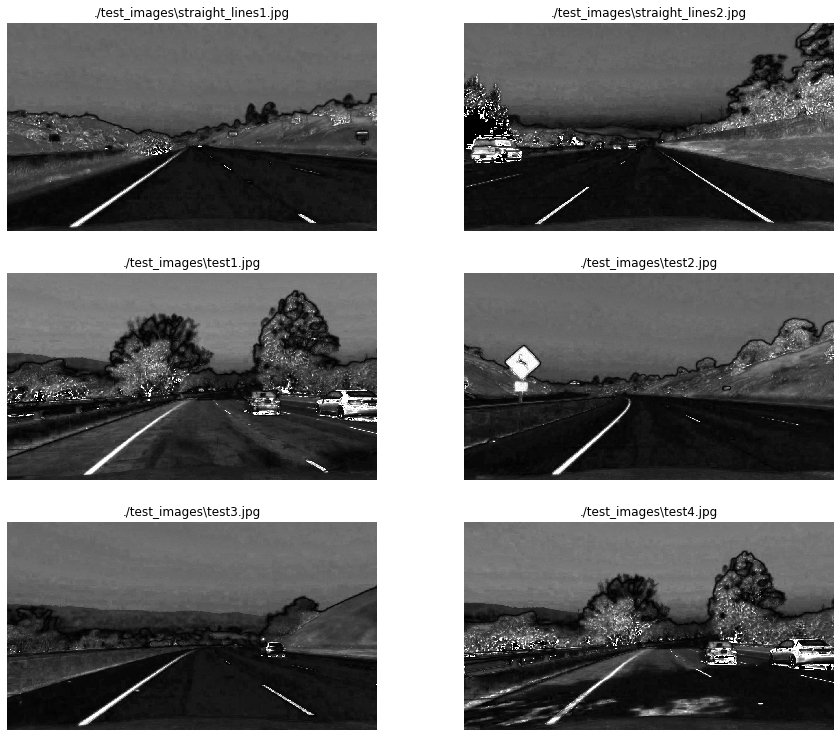

In [6]:
def applyActionToImages(images, action):
    return list(map(lambda img: (img[0], action(img[1])), images))

# Method to plot images on cols / rows 
def showImages(images, cols = 4, rows = 5, figsize=(15,10), cmap = None):
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            if cmap == None:
                ax.imshow(image)
            else:
                ax.imshow(image, cmap=cmap)
            ax.set_title(imagePathName)
            ax.axis('off')
    
# Get camera matrix and distortion coefficient
mtx, dist = getCameraCalibrationCoefficientsFromPickleFile('./pickled_data/camera_calibration.p')
    
# Lambda action applied on all images
useSChannel = lambda img: undistortImageAndGetHLS(img, mtx, dist)[2]

# Get Test images
testImages = getTestImages('./test_images/*.jpg')

# Get all 'S' channels from all Test images
resultSChannel = applyActionToImages(testImages, useSChannel)

# Show our result
#showImages(resultSChannel, 2, 3, (15, 13), cmap='gray')


In [7]:
# Apply Sobel in 'x' direction and plot images
applySobelX = lambda img: applySobel(useSChannel(img), orient='x', thresh_min=10, thresh_max=160)

# Get all 'S' channels from all Test images
resultApplySobelX = applyActionToImages(testImages, applySobelX)

# Show our result
#showImages(resultApplySobelX, 2, 3, (15, 13), cmap='gray')

In [8]:
# Apply Sobel in 'y' direction and plot images
applySobelY = lambda img: applySobel(useSChannel(img), orient='y', thresh_min=10, thresh_max=160)

# Get all 'S' channels from all Test images
resultApplySobelY = applyActionToImages(testImages, applySobelY)

# Show our result
#showImages(resultApplySobelY, 2, 3, (15, 13), cmap='gray')

In [9]:
def mag_thresh(img, sobel_kernel=3, thresh_min = 0, thresh_max = 255):
    # Apply the following steps to img
    # 1) Take the gradient in x and y separately
    sobelX = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 2) Calculate the magnitude
    gradmag = np.sqrt(sobelX**2 + sobelY**2)
    # 3) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # 4) Create a binary mask where mag thresholds are met
    binary_output = thresh(gradmag,thresh_min, thresh_max)
    # 5) Return this mask as your binary_output image
    return binary_output

In [10]:
# Apply Magnitude in 'x' and 'y' directions in order to calcultate the magnitude of pixels and plot images
applyMagnitude = lambda img: mag_thresh(useSChannel(img), thresh_min=5, thresh_max=160)

# Apply the lamnda function to all test images
resultMagnitudes = applyActionToImages(testImages, applyMagnitude)

# Show our result
#showImages(resultMagnitudes, 2, 3, (15, 13), cmap='gray')

In [11]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh_min = 0, thresh_max = np.pi/2):
    # 1) Take the gradient in x and y separately and 
    # Take the absolute value of the x and y gradients
    sobelX = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobelY = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # 2) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # sobelY / sobelX 
    gradientDirection = np.arctan2(sobelY, sobelX)
    # 3) Create a binary mask where direction thresholds are met
    binary_output = thresh(gradientDirection, thresh_min, thresh_max)
    # 4) Return this mask as your binary_output image
    return binary_output

In [12]:
# Apply direction of the gradient
applyDirection = lambda img: dir_threshold(useSChannel(img), thresh_min=0.79, thresh_max=1.20)

# Apply the lambda function to all test images
resultDirection = applyActionToImages(testImages, applyDirection)

# Show our result
#showImages(resultDirection, 2, 3, (15, 13), cmap='gray')

In [13]:
def combineGradients(img):
    sobelX = applySobelX(img)
    sobelY = applySobelY(img)
    magnitude = applyMagnitude(img)
    direction = applyDirection(img)
    combined = np.zeros_like(sobelX) 
    combined[((sobelX == 1) & (sobelY == 1)) | ((magnitude == 1) & (direction == 1))] = 1
    return combined

resultCombined = applyActionToImages(testImages, combineGradients)

# Show our result
#showImages(resultCombined, 2, 3, (15, 13), cmap='gray')

In [14]:
def show_compared_results():
    titles = ['Apply Sobel X', 'Apply Sobel Y', 'Apply Magnitude', 'Apply Direction', 'Combined']
    results = list(zip(resultApplySobelX, resultApplySobelY, resultMagnitudes, resultDirection, resultCombined))
    # only 5 images
    resultsAndTitle = list(map(lambda images: list(zip(titles, images)), results))[3:6]
    flattenResults = [item for sublist in resultsAndTitle for item in sublist]
    fig, axes = plt.subplots(ncols=5, nrows=len(resultsAndTitle), figsize=(25,10))
    for ax, imageTuple in zip(axes.flat, flattenResults):
        title, images = imageTuple
        imagePath, img = images
        ax.imshow(img, cmap='gray')
        ax.set_title(imagePath + '\n' + title, fontsize=8)
        ax.axis('off')
    fig.subplots_adjust(hspace=0, wspace=0.05, bottom=0)